In [2]:
import matplotlib
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from utils import display_pca_scatterplot
import json
import pandas as pd
import random
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score, classification_report
from spacy.tokenizer import Tokenizer
from spacy.lang.tr import Turkish
import numpy as np
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

In [3]:
train_path = '../Boun Twitter Data/train.json'
val_path = '../Boun Twitter Data/validation.json'
test_path = '../Boun Twitter Data/test.json'
cappy_path = '../Other Data/cappy.json'
bege_path = '../Other Data/berkcan.json'
netflix_path = '../Other Data/netflix.json'
device = 'cuda'

In [4]:
def filter(text):
    final_text = ''
    for word in text.split():
        if word.startswith('@'):
            continue
        elif word[-3:] in ['com', 'org']:
            continue
        elif word.startswith('pic') or word.startswith('http') or word.startswith('www'):
            continue
        else:
            final_text += word+' '
    return final_text

In [5]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")
bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-128k-uncased").to(device)

def feature_extraction(text):
    x = tokenizer.encode(filter(text))
    with torch.no_grad():
        x, _ = bert(torch.stack([torch.tensor(x)]).to(device))
        return list(x[0][0].cpu().numpy())

In [6]:
with open(train_path, 'r') as f:
    train = json.load(f)
with open(val_path, 'r') as f:
    val = json.load(f)
with open(test_path, 'r') as f:
    test = json.load(f)

train = train+val

In [7]:
mapping = {'negative':0, 'neutral':1, 'positive':2}
X_train = []
y_train = []
X_test = []
y_test = []
for element in tqdm(train):
    X_train.append(feature_extraction(element['sentence']))
    y_train.append(mapping[element['value']])
for element in tqdm(test):
    X_test.append(feature_extraction(element['sentence']))
    y_test.append(mapping[element['value']])

100%|██████████| 1592/1592 [00:11<00:00, 143.55it/s]


## Visualization of Sentence Vectors

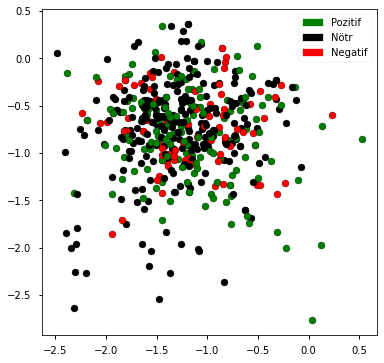

In [8]:
display_pca_scatterplot(X_train, y_train, 500)

## Training a Model with Simple MLP

In [9]:
model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, activation='tanh', solver='adam', alpha=1e-5, learning_rate='constant',
                      verbose=1, early_stopping=True)
model.fit(X_train, y_train)
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))

Iteration 1, loss = 0.93023080
Validation score: 0.636364
Iteration 2, loss = 0.78435388
Validation score: 0.691223
Iteration 3, loss = 0.73371059
Validation score: 0.697492
Iteration 4, loss = 0.69251550
Validation score: 0.699060
Iteration 5, loss = 0.66386549
Validation score: 0.695925
Iteration 6, loss = 0.64749522
Validation score: 0.697492
Iteration 7, loss = 0.62206344
Validation score: 0.711599
Iteration 8, loss = 0.59697573
Validation score: 0.706897
Iteration 9, loss = 0.58692890
Validation score: 0.708464
Iteration 10, loss = 0.56605951
Validation score: 0.695925
Iteration 11, loss = 0.55400458
Validation score: 0.699060
Iteration 12, loss = 0.53507462
Validation score: 0.692790
Iteration 13, loss = 0.50543426
Validation score: 0.714734
Iteration 14, loss = 0.51464311
Validation score: 0.691223
Iteration 15, loss = 0.49638762
Validation score: 0.689655
Iteration 16, loss = 0.45459768
Validation score: 0.692790
Iteration 17, loss = 0.44022765
Validation score: 0.702194
Iterat

# Analysis

## Cappy Analysis

In [10]:
cappy_df = pd.read_json(cappy_path).query('is_retweet==False').drop_duplicates(['text'])[['text', 'datetime']]
cappy_df['value'] = 0
#-1 negative 0 neutral 1 positive
for idx, row in tqdm(cappy_df.iterrows()):
    X = feature_extraction(row['text'])
    cappy_df.at[idx, 'value'] = model.predict([X])[0]-1

13717it [02:13, 102.59it/s]


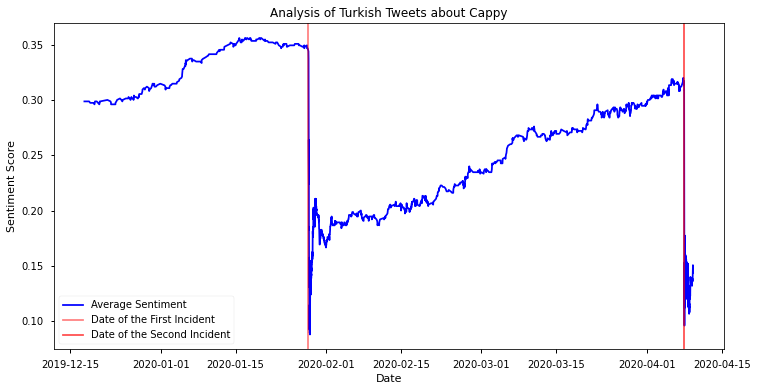

In [13]:
incident1 = datetime.strptime('2020-01-28 15:20:00', '%Y-%m-%d %H:%M:%S')
incident2 = datetime.strptime('2020-04-07 19:34:00', '%Y-%m-%d %H:%M:%S')
dates = np.array(cappy_df['datetime'])
indices = np.argsort(dates)[5300:]
window = 750

dates = dates[indices][window:]
values = np.array(cappy_df['value'])[indices]
windows = pd.Series(values).rolling(window)
moving_averages = windows.mean()[window:]


plt.figure(figsize=(12,6))
plt.plot(dates, moving_averages, color='blue', label='Average Sentiment')

plt.axvline(incident1, 0, 1, label='Date of the First Incident', color='red', alpha=0.5)
plt.axvline(incident2, 0, 1, label='Date of the Second Incident', color='red', alpha=0.7)
plt.title('Analysis of Turkish Tweets about Cappy')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend();

## Netflix Analysis

In [12]:
netflix_df = pd.read_json(netflix_path).query('is_retweet==False').drop_duplicates(['text'])[['text', 'datetime']]
netflix_df['value'] = 0
#-1 negative 0 neutral 1 positive
for idx, row in tqdm(netflix_df.iterrows()):
    X = feature_extraction(row['text'])
    netflix_df.at[idx, 'value'] = model.predict([X])[0]-1

13948it [02:18, 101.04it/s]


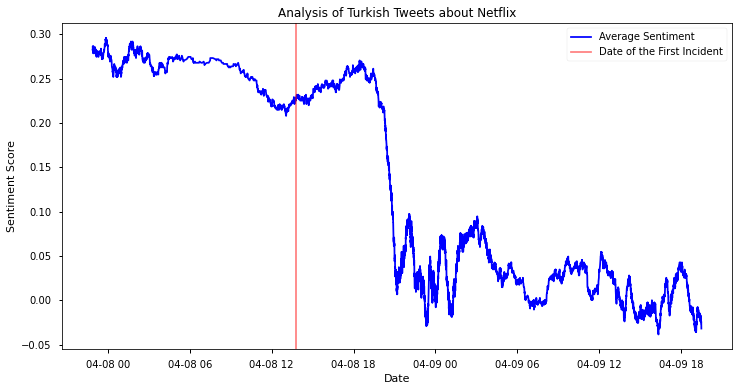

In [15]:
incident1 = datetime.strptime('2020-04-08 13:48:00', '%Y-%m-%d %H:%M:%S')
dates = np.array(netflix_df['datetime'])
indices = np.argsort(dates)
window = 750

dates = dates[indices][window:]
values = np.array(netflix_df['value'])[indices]
windows = pd.Series(values).rolling(window)
moving_averages = windows.mean()[window:]


plt.figure(figsize=(12,6))
plt.plot(dates, moving_averages, color='blue', label='Average Sentiment')

plt.axvline(incident1, 0, 1, label='Date of the First Incident', color='red', alpha=0.5)
plt.title('Analysis of Turkish Tweets about Netflix')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend();

## Berkcan Guven Analysis

In [16]:
bege_df = pd.read_json(bege_path).query('is_retweet==False').drop_duplicates(['text'])[['text', 'datetime']]
bege_df['value'] = 0
#-1 negative 0 neutral 1 positive
for idx, row in tqdm(bege_df.iterrows()):
    X = feature_extraction(row['text'])
    bege_df.at[idx, 'value'] = model.predict([X])[0]-1

14274it [02:11, 108.69it/s]


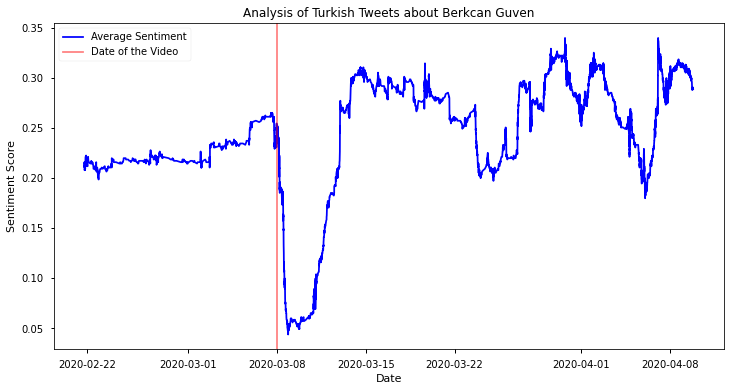

In [17]:
incident1 = datetime.strptime('2020-03-07 23:11:00', '%Y-%m-%d %H:%M:%S')
dates = np.array(bege_df['datetime'])
indices = np.argsort(dates)
window = 750

dates = dates[indices][window:]
values = np.array(bege_df['value'])[indices]
windows = pd.Series(values).rolling(window)
moving_averages = windows.mean()[window:]


plt.figure(figsize=(12,6))
plt.plot(dates, moving_averages, color='blue', label='Average Sentiment')

plt.axvline(incident1, 0, 1, label='Date of the Video', color='red', alpha=0.5)
plt.title('Analysis of Turkish Tweets about Berkcan Guven')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend();